In [62]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, jaccard_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from skimage.feature import graycomatrix, graycoprops
import os
import glob

In [60]:

def compute_histogram(gray_image, bins=256):

    if gray_image.dtype != np.uint8:
        gray_image = gray_image.astype(np.uint8)
    
    hist = cv2.calcHist([gray_image], [0], None, [bins], [0, 256])
    hist = hist.flatten()
    hist = hist / hist.sum()
    values = np.arange(bins)
    features = {}

    features['mean'] = np.sum(hist * values)

    variance = np.sum(hist * (values - features['mean'])**2)
    features['std'] = np.sqrt(variance)

    if features['std'] > 0:
        features['skewness'] = np.sum(hist * ((values - features['mean']) / features['std'])**3)
    else:
        features['skewness'] = 0

    if features['std'] > 0:
        features['kurtosis'] = np.sum(hist * ((values - features['mean']) / features['std'])**4) - 3
    else:
        features['kurtosis'] = -3

    non_zero_probs = hist[hist > 0]
    features['entropy'] = -np.sum(non_zero_probs * np.log2(non_zero_probs))

    cumulative_hist = np.cumsum(hist)
    features['q1'] = np.argmax(cumulative_hist >= 0.25) 
    features['q2'] = np.argmax(cumulative_hist >= 0.5)  
    features['q3'] = np.argmax(cumulative_hist >= 0.75) 

    non_zero_bins = np.where(hist > 0)[0]
    if len(non_zero_bins) > 0:
        features['min'] = non_zero_bins[0]
        features['max'] = non_zero_bins[-1]
    else:
        features['min'] = 0
        features['max'] = 255
    
    return features, hist

def extract_histogram_features(gray_image, bins=256):
    """Извлечение признаков из гистограммы"""
    stats_dict, hist = compute_histogram(gray_image, bins)
    
    features = [
        stats_dict['mean'],
        stats_dict['std'],
        stats_dict['skewness'],
        stats_dict['kurtosis'],
        stats_dict['entropy'],
        stats_dict['q1'],
        stats_dict['q2'], 
        stats_dict['q3'],
        stats_dict['min'],
        stats_dict['max']
    ]
    
    return np.array(features)

def laws_texture_features(image, normalize=True):
    """Вычисление текстурных признаков по методу Laws"""
    L5 = np.array([1,  4,  6,  4,  1])   # Level (усреднение)
    E5 = np.array([-1, -2,  0,  2,  1])  # Edge (края)
    S5 = np.array([-1,  0,  2,  0, -1])  # Spot (пятна)
    W5 = np.array([-1,  2,  0, -2,  1])  # Wave (волны)
    R5 = np.array([1,  -4,  6, -4,  1])  # Ripple (рябь)
    
    masks_1d = [L5, E5, S5, W5, R5]
    masks_names = ['L5', 'E5', 'S5', 'W5', 'R5']
    
    filters_2d = []
    filter_names = []
    

    for i, mask1 in enumerate(masks_1d):
        for j, mask2 in enumerate(masks_1d):
            kernel = np.outer(mask1, mask2)
            filters_2d.append(kernel)
            filter_names.append(f"{masks_names[i]}{masks_names[j]}")
    
    features = []
    feature_names = []

    for kernel, name in zip(filters_2d, filter_names):
        filtered = cv2.filter2D(image.astype(np.float32), -1, kernel)
        energy = np.mean(filtered ** 2)
        features.append(energy)
        feature_names.append(f"laws_{name}")
    
    features = np.array(features)

    if normalize and np.sum(features) > 0:
        features = features / np.sum(features)
    
    return features, feature_names

def compute_glcm_features(image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):

    image = (image // 8).astype(np.uint8)

    glcm = graycomatrix(image, distances=distances, angles=angles, 
                       levels=32, symmetric=True, normed=True)
    
    features = []
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']

    for prop in props:
        feature_val = np.mean(graycoprops(glcm, prop))
        features.append(feature_val)
    
    return np.array(features)

print("Функции для вычисления текстурных характеристик загружены")

Функции для вычисления текстурных характеристик загружены


In [59]:

print("СОЗДАНИЕ ТЕСТОВЫХ ТЕКСТУР")

np.random.seed(42)
test_textures = []

texture1 = np.random.normal(128, 10, (128, 128)).clip(0, 255).astype(np.uint8)
test_textures.append(("Низкая контрастность", texture1))

texture2 = np.random.choice([50, 200], (128, 128), p=[0.5, 0.5])
test_textures.append(("Высокая контрастность", texture2))


texture3 = np.zeros((128, 128), dtype=np.uint8)
for i in range(128):
    texture3[:, i] = (i % 32) * 8
test_textures.append(("Вертикальные полосы", texture3))

print(f"Создано {len(test_textures)} тестовых текстур для демонстрации")

СОЗДАНИЕ ТЕСТОВЫХ ТЕКСТУР
Создано 3 тестовых текстур для демонстрации


ПУНКТ 1.1: ГИСТОГРАММНЫЕ ХАРАКТЕРИСТИКИ

Текстура 1: Низкая контрастность


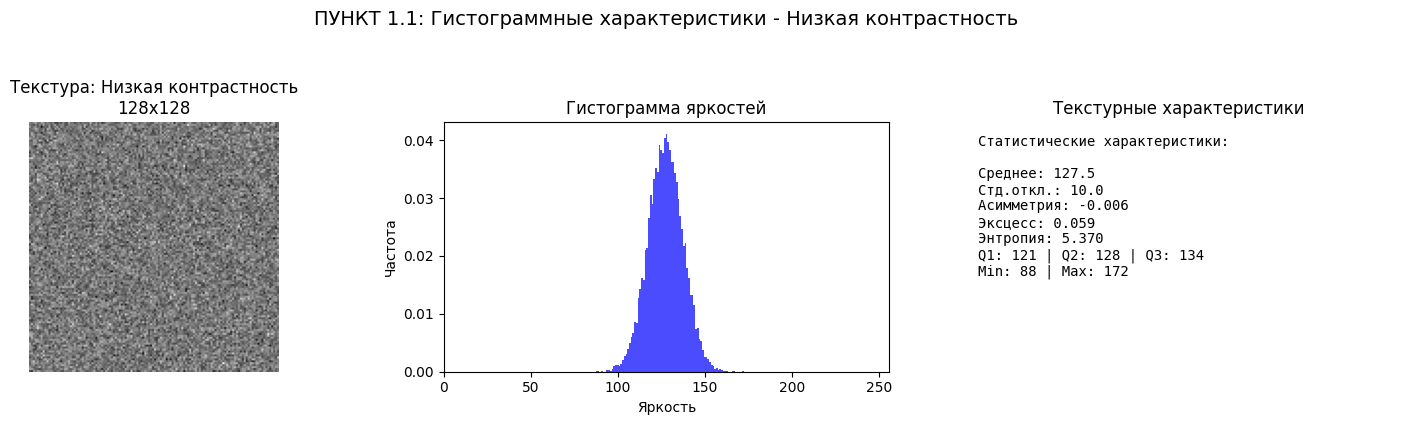

  Среднее: 127.5, Стд.откл.: 10.0, Энтропия: 5.370

Текстура 2: Высокая контрастность


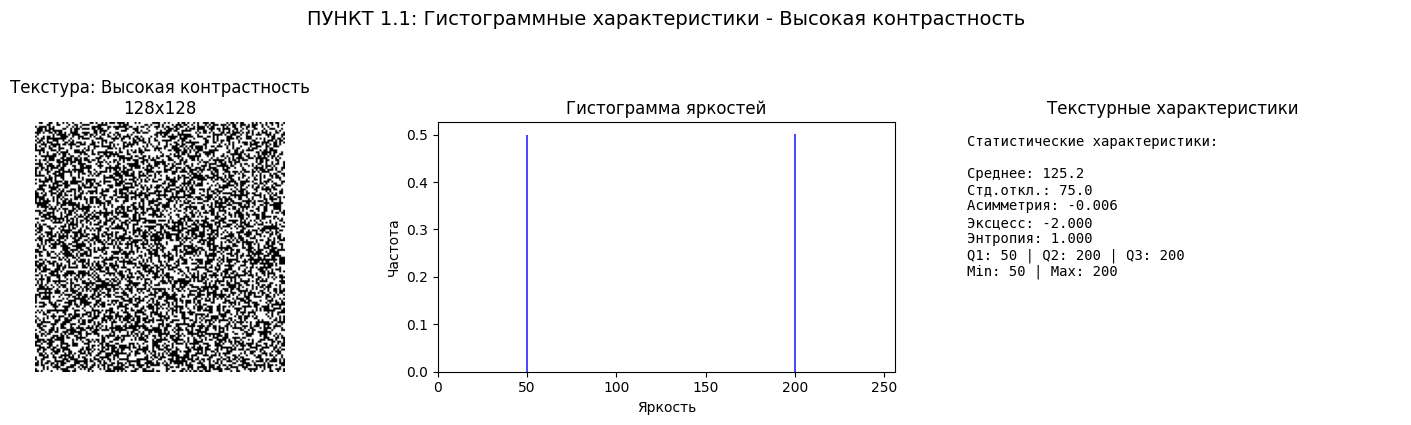

  Среднее: 125.2, Стд.откл.: 75.0, Энтропия: 1.000

Текстура 3: Вертикальные полосы


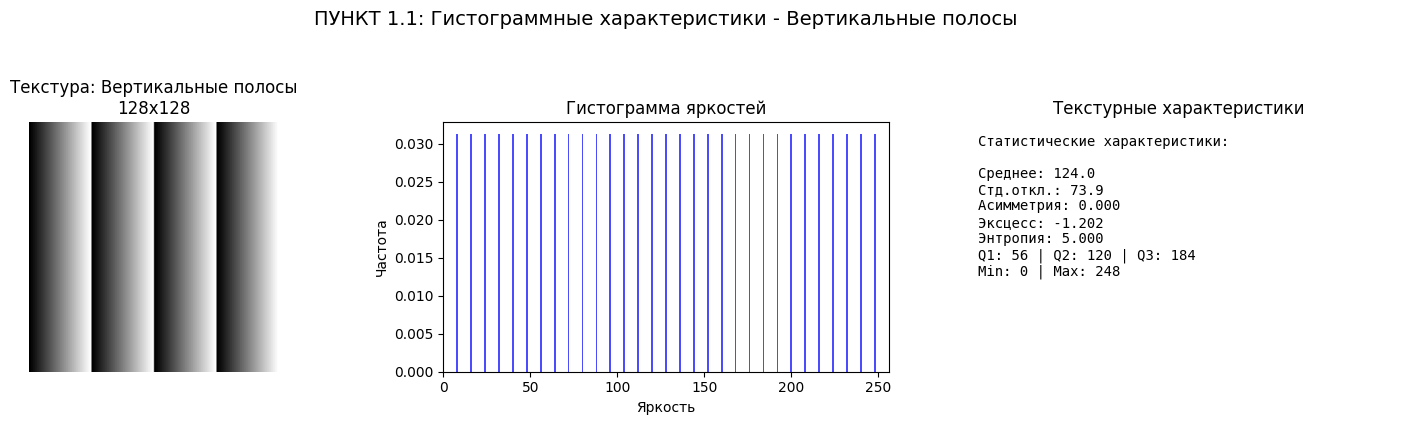

  Среднее: 124.0, Стд.откл.: 73.9, Энтропия: 5.000


In [58]:

print("ПУНКТ 1.1: ГИСТОГРАММНЫЕ ХАРАКТЕРИСТИКИ")

for i, (name, texture) in enumerate(test_textures):
    print(f"\nТекстура {i+1}: {name}")

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    features, hist = compute_histogram(texture)

    axes[0].imshow(texture, cmap='gray')
    axes[0].set_title(f'Текстура: {name}\n{texture.shape[0]}x{texture.shape[1]}')
    axes[0].axis('off')

    axes[1].bar(range(256), hist, alpha=0.7, color='blue', width=1.0)
    axes[1].set_title('Гистограмма яркостей')
    axes[1].set_xlabel('Яркость')
    axes[1].set_ylabel('Частота')
    axes[1].set_xlim([0, 256])

    metrics_text = (
        f"Статистические характеристики:\n\n"
        f"Среднее: {features['mean']:.1f}\n"
        f"Стд.откл.: {features['std']:.1f}\n"
        f"Асимметрия: {features['skewness']:.3f}\n"
        f"Эксцесс: {features['kurtosis']:.3f}\n"
        f"Энтропия: {features['entropy']:.3f}\n"
        f"Q1: {features['q1']} | Q2: {features['q2']} | Q3: {features['q3']}\n"
        f"Min: {features['min']} | Max: {features['max']}"
    )
    
    axes[2].text(0.05, 0.95, metrics_text, transform=axes[2].transAxes, 
                fontsize=10, verticalalignment='top', fontfamily='monospace')
    axes[2].set_title('Текстурные характеристики')
    axes[2].axis('off')
    
    plt.suptitle(f'ПУНКТ 1.1: Гистограммные характеристики - {name}', fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()
    
    print(f"  Среднее: {features['mean']:.1f}, Стд.откл.: {features['std']:.1f}, "
          f"Энтропия: {features['entropy']:.3f}")

ПУНКТ 1.2: ХАРАКТЕРИСТИКИ ЛОУСА (LAWS)

Текстура 1: Низкая контрастность


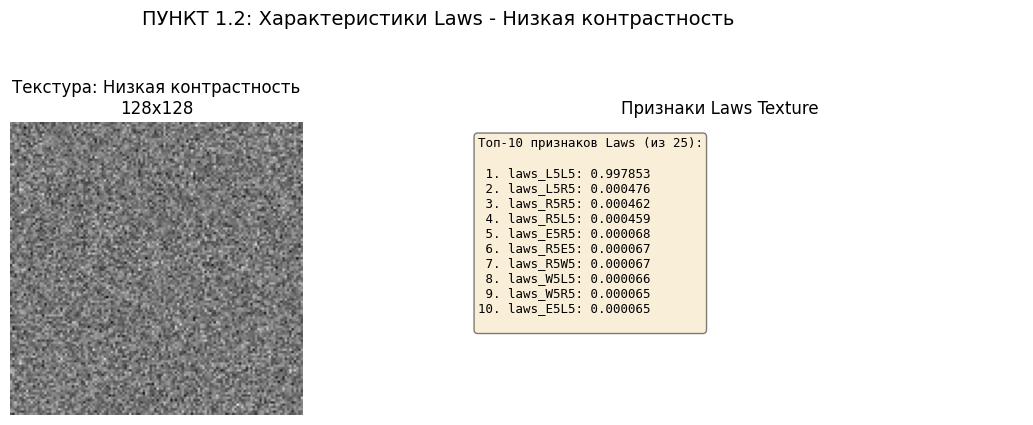

  Суммарная энергия Laws: 1.0000
  Макс. признак: laws_L5L5 = 0.997853

Текстура 2: Высокая контрастность


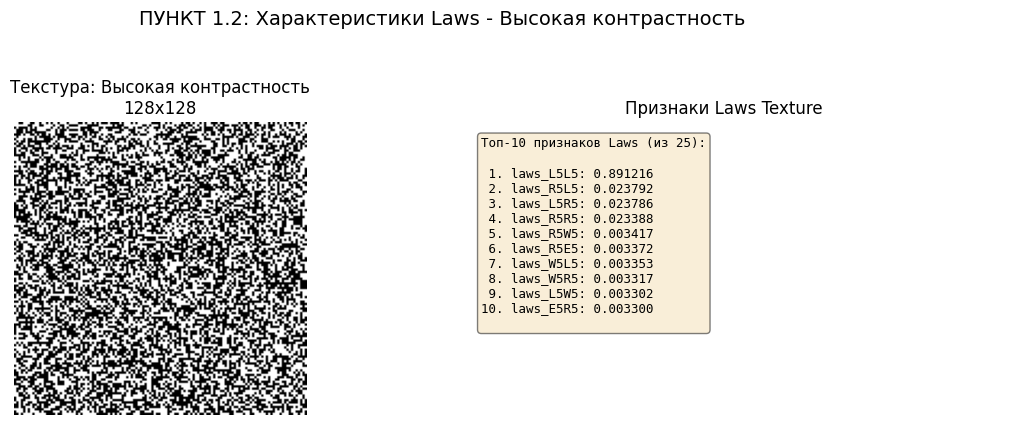

  Суммарная энергия Laws: 1.0000
  Макс. признак: laws_L5L5 = 0.891216

Текстура 3: Вертикальные полосы


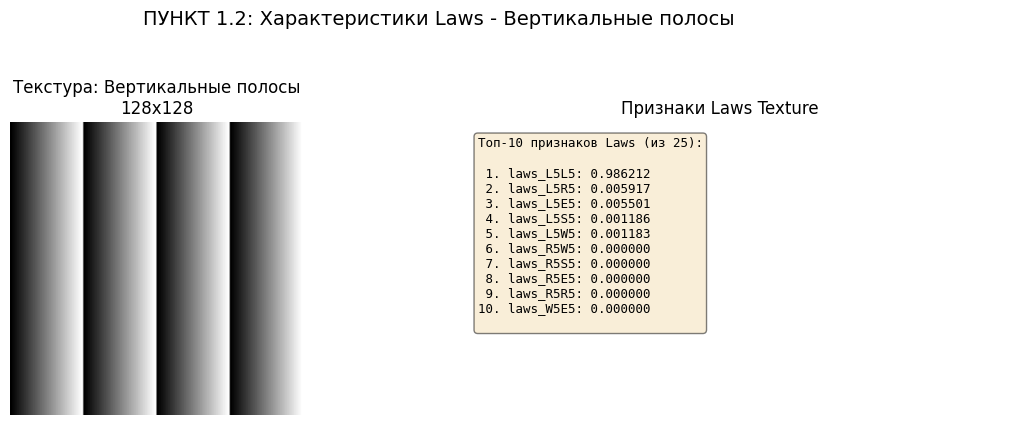

  Суммарная энергия Laws: 1.0000
  Макс. признак: laws_L5L5 = 0.986212


In [57]:

print("ПУНКТ 1.2: ХАРАКТЕРИСТИКИ ЛОУСА (LAWS)")

for i, (name, texture) in enumerate(test_textures):
    print(f"\nТекстура {i+1}: {name}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    features, names = laws_texture_features(texture)

    axes[0].imshow(texture, cmap='gray')
    axes[0].set_title(f'Текстура: {name}\n{texture.shape[0]}x{texture.shape[1]}')
    axes[0].axis('off')

    top_indices = np.argsort(features)[-10:][::-1]
    laws_text = "Топ-10 признаков Laws (из 25):\n\n"
    for j, idx in enumerate(top_indices):
        laws_text += f"{j+1:2d}. {names[idx]}: {features[idx]:.6f}\n"
    
    axes[1].text(0.1, 0.95, laws_text, transform=axes[1].transAxes, 
                fontsize=9, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    axes[1].set_title('Признаки Laws Texture')
    axes[1].axis('off')
    
    plt.suptitle(f'ПУНКТ 1.2: Характеристики Laws - {name}', fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

    print(f"  Суммарная энергия Laws: {np.sum(features):.4f}")
    print(f"  Макс. признак: {names[top_indices[0]]} = {features[top_indices[0]]:.6f}")

ПУНКТ 1.3: ХАРАКТЕРИСТИКИ GLCM

Текстура 1: Низкая контрастность


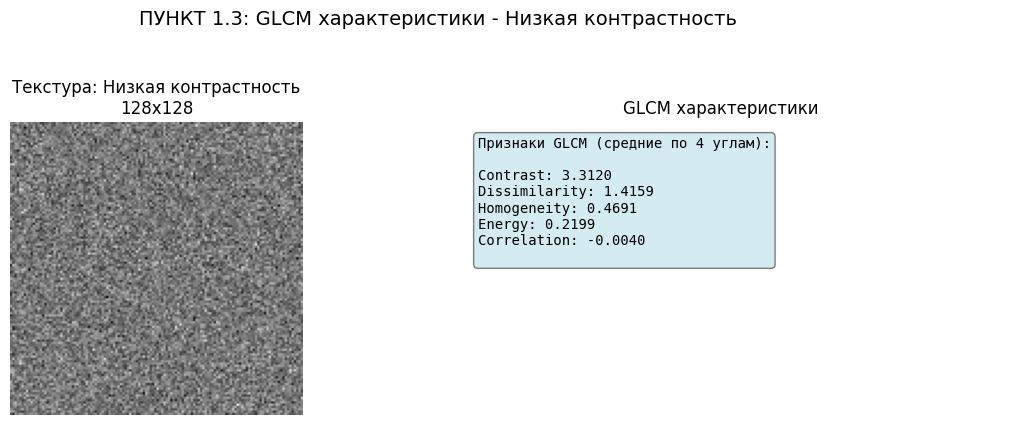

  Контраст: 3.3120, Однородность: 0.4691, Энергия: 0.2199

Текстура 2: Высокая контрастность


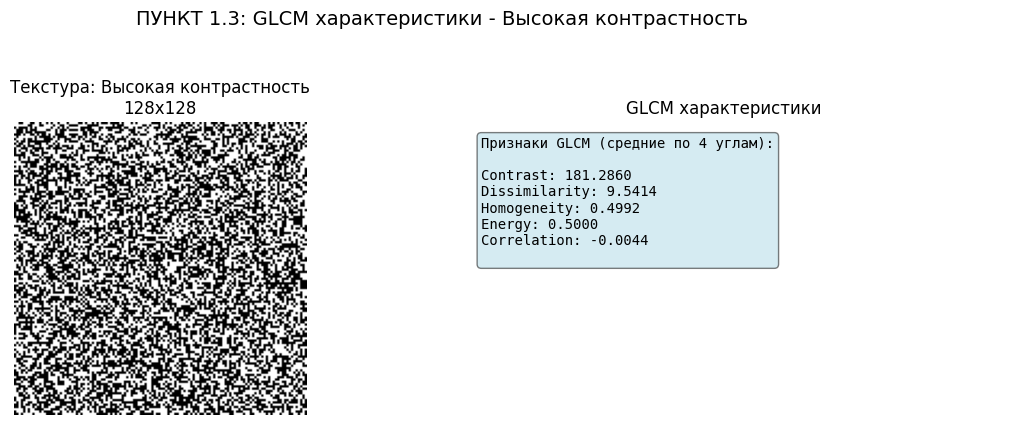

  Контраст: 181.2860, Однородность: 0.4992, Энергия: 0.5000

Текстура 3: Вертикальные полосы


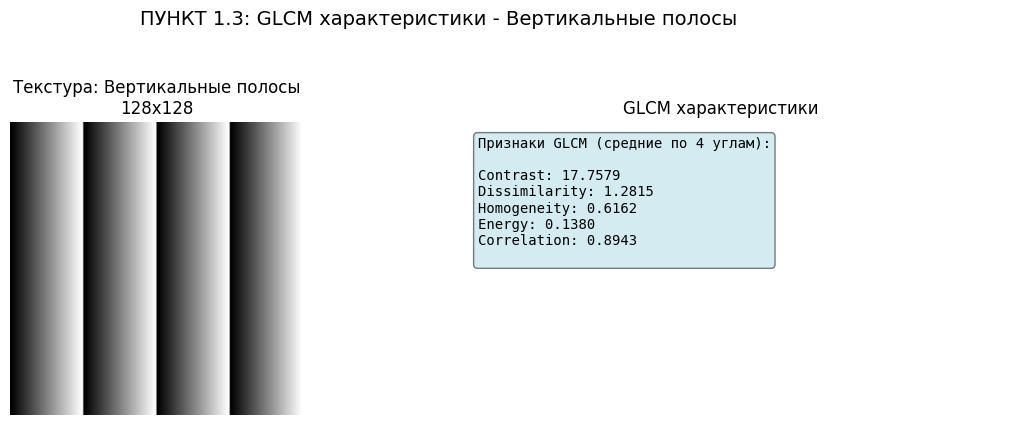

  Контраст: 17.7579, Однородность: 0.6162, Энергия: 0.1380


In [56]:

print("ПУНКТ 1.3: ХАРАКТЕРИСТИКИ GLCM")


for i, (name, texture) in enumerate(test_textures):
    print(f"\nТекстура {i+1}: {name}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    glcm_features = compute_glcm_features(texture)

    axes[0].imshow(texture, cmap='gray')
    axes[0].set_title(f'Текстура: {name}\n{texture.shape[0]}x{texture.shape[1]}')
    axes[0].axis('off')

    glcm_names = ['Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation']
    glcm_text = "Признаки GLCM (средние по 4 углам):\n\n"
    for j, (feature_name, feature_value) in enumerate(zip(glcm_names, glcm_features)):
        glcm_text += f"{feature_name}: {feature_value:.4f}\n"
    
    axes[1].text(0.1, 0.95, glcm_text, transform=axes[1].transAxes, 
                fontsize=10, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    axes[1].set_title('GLCM характеристики')
    axes[1].axis('off')
    
    plt.suptitle(f'ПУНКТ 1.3: GLCM характеристики - {name}', fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

    print(f"  Контраст: {glcm_features[0]:.4f}, Однородность: {glcm_features[2]:.4f}, "
          f"Энергия: {glcm_features[3]:.4f}")


ЗАДАНИЕ 2: ТРЕНИРОВКА КЛАССИФИКАТОРОВ
Создание синтетического набора данных...
Создано 120 образцов, 4 классов
Размер признаков: Histogram=10, Laws=25, GLCM=5

Классы: ['Текстура_1' 'Текстура_2' 'Текстура_3' 'Текстура_4']
Количество образцов: 120
Распределение по классам: [30 30 30 30]


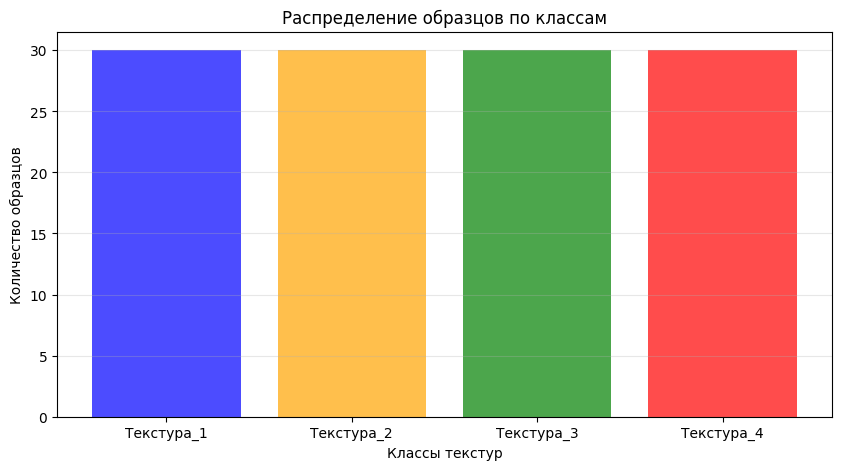

In [ ]:

print("ЗАДАНИЕ 2: ТРЕНИРОВКА КЛАССИФИКАТОРОВ")


def create_classification_dataset():
    """Создание синтетического набора данных для классификации текстур"""
    print("Создание синтетического набора данных...")
    
    n_samples_per_class = 30
    n_classes = 4 
    
    X_hist = []
    X_laws = []
    X_glcm = []
    y = []
    
    for class_idx in range(n_classes):
        class_name = f'Текстура_{class_idx+1}'

        for sample_idx in range(n_samples_per_class):
            if class_idx == 0:  
                texture = np.random.normal(128, 5 + sample_idx*0.2, (64, 64)).clip(0, 255).astype(np.uint8)
            elif class_idx == 1:  # Высокая контрастность
                texture = np.random.choice([30, 220], (64, 64), p=[0.5, 0.5])
            elif class_idx == 2:  # Вертикальные полосы
                texture = np.zeros((64, 64), dtype=np.uint8)
                for i in range(64):
                    texture[:, i] = ((i + sample_idx) % 16) * 16
            else:
                texture = np.zeros((64, 64), dtype=np.uint8)
                for i in range(64):
                    texture[i, :] = ((i + sample_idx) % 16) * 16

            hist_features = extract_histogram_features(texture)
            laws_features, _ = laws_texture_features(texture)
            glcm_features = compute_glcm_features(texture)
            
            X_hist.append(hist_features)
            X_laws.append(laws_features)
            X_glcm.append(glcm_features)
            y.append(class_name)
    
    print(f"Создано {len(y)} образцов, {n_classes} классов")
    print(f"Размер признаков: Histogram={len(X_hist[0])}, Laws={len(X_laws[0])}, GLCM={len(X_glcm[0])}")
    
    return np.array(X_hist), np.array(X_laws), np.array(X_glcm), np.array(y)

X_hist, X_laws, X_glcm, y = create_classification_dataset()

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"\nКлассы: {le.classes_}")
print(f"Количество образцов: {len(y_encoded)}")
print(f"Распределение по классам: {np.bincount(y_encoded)}")

plt.figure(figsize=(10, 5))
classes, counts = np.unique(y, return_counts=True)
plt.bar(classes, counts, color=['blue', 'orange', 'green', 'red'], alpha=0.7)
plt.title('Распределение образцов по классам')
plt.xlabel('Классы текстур')
plt.ylabel('Количество образцов')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [55]:

test_size = 0.25
random_state = 42

methods = {
    'Histogram': X_hist,
    'Laws': X_laws,
    'GLCM': X_glcm
}

models = {
    'kNN': KNeighborsClassifier(n_neighbors=3),
    'SVM': SVC(kernel='rbf', random_state=random_state),
    'DecisionTree': DecisionTreeClassifier(max_depth=10, random_state=random_state)
}

results = {}
trained_models = {}

for method_name, X in methods.items():
    print(f"\n{'='*50}")
    print(f"МЕТОД: {method_name}")
    print('='*50)
    
    # Разделение данных
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=test_size, 
        random_state=random_state, stratify=y_encoded
    )
    
    method_results = {}
    
    for model_name, model in models.items():
        print(f"\nМодель: {model_name}")

        if model_name == 'SVM':
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)

            trained_models[f'{method_name}_{model_name}'] = (model, scaler)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            trained_models[f'{method_name}_{model_name}'] = model

        accuracy = accuracy_score(y_test, y_pred)
        print(f"  Точность: {accuracy:.3f}")
        
        method_results[model_name] = {
            'accuracy': accuracy,
            'y_test': y_test,
            'y_pred': y_pred
        }
    
    results[method_name] = method_results

print(f"\nОбучено моделей: {len(trained_models)}")


МЕТОД: Histogram

Модель: kNN
  Точность: 0.767

Модель: SVM
  Точность: 0.733

Модель: DecisionTree
  Точность: 0.733

МЕТОД: Laws

Модель: kNN
  Точность: 1.000

Модель: SVM
  Точность: 1.000

Модель: DecisionTree
  Точность: 1.000

МЕТОД: GLCM

Модель: kNN
  Точность: 0.700

Модель: SVM
  Точность: 0.733

Модель: DecisionTree
  Точность: 0.600

Обучено моделей: 9


РЕЗУЛЬТАТЫ КЛАССИФИКАЦИИ

ЛУЧШИЙ РЕЗУЛЬТАТ:
  Метод: Laws
  Модель: kNN
  Точность: 1.000

ОТЧЕТ О КЛАССИФИКАЦИИ (Laws + kNN):
              precision    recall  f1-score   support

  Текстура_1       1.00      1.00      1.00         8
  Текстура_2       1.00      1.00      1.00         7
  Текстура_3       1.00      1.00      1.00         8
  Текстура_4       1.00      1.00      1.00         7

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ:


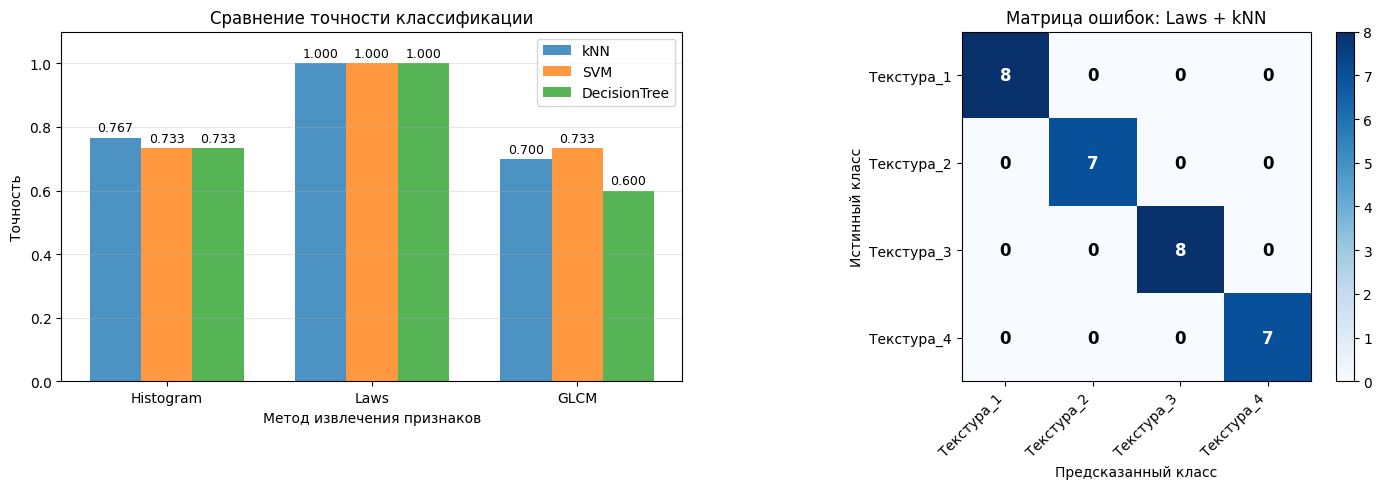

In [53]:

print("РЕЗУЛЬТАТЫ КЛАССИФИКАЦИИ")

best_method = None
best_accuracy = 0
best_model = None

for method_name in results.keys():
    for model_name in results[method_name]:
        accuracy = results[method_name][model_name]['accuracy']
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_method = method_name
            best_model = model_name

print(f"\nЛУЧШИЙ РЕЗУЛЬТАТ:")
print(f"  Метод: {best_method}")
print(f"  Модель: {best_model}")
print(f"  Точность: {best_accuracy:.3f}")

print(f"\nОТЧЕТ О КЛАССИФИКАЦИИ ({best_method} + {best_model}):")
y_test_best = results[best_method][best_model]['y_test']
y_pred_best = results[best_method][best_model]['y_pred']
print(classification_report(y_test_best, y_pred_best, target_names=le.classes_))

print("\nВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ:")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
method_names = list(results.keys())
model_names = list(models.keys())

# Собираем данные для графика
accuracy_data = []
for method_name in method_names:
    accuracies = [results[method_name][model]['accuracy'] for model in model_names]
    accuracy_data.append(accuracies)

accuracy_data = np.array(accuracy_data)

x = np.arange(len(method_names))
width = 0.25

for i, model_name in enumerate(model_names):
    offset = (i - 1) * width
    bars = ax1.bar(x + offset, accuracy_data[:, i], width, 
                  label=model_name, alpha=0.8)
    
    # Добавляем значения на столбцы
    for bar, value in zip(bars, accuracy_data[:, i]):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontsize=9)

ax1.set_xlabel('Метод извлечения признаков')
ax1.set_ylabel('Точность')
ax1.set_title('Сравнение точности классификации')
ax1.set_xticks(x)
ax1.set_xticklabels(method_names)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1.1])

ax2 = axes[1]
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_best, y_pred_best)

im = ax2.imshow(cm, cmap='Blues', interpolation='nearest')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
        ax2.text(j, i, str(cm[i, j]), ha='center', va='center', 
                color=text_color, fontsize=12, fontweight='bold')

ax2.set_xlabel('Предсказанный класс')
ax2.set_ylabel('Истинный класс')
ax2.set_title(f'Матрица ошибок: {best_method} + {best_model}')
ax2.set_xticks(range(len(le.classes_)))
ax2.set_yticks(range(len(le.classes_)))
ax2.set_xticklabels(le.classes_, rotation=45, ha='right')
ax2.set_yticklabels(le.classes_)

plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

ЗАДАНИЕ 3: СЕГМЕНТАЦИЯ ИЗОБРАЖЕНИЯ
Тестовое изображение создано: (256, 256)


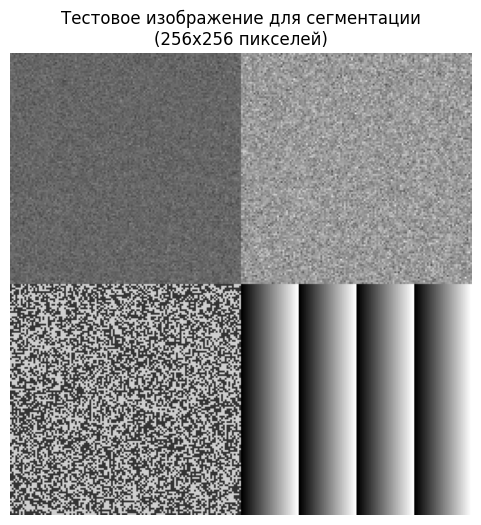


Описание областей изображения:
1. Верхний левый: Низкая контрастность
2. Верхний правый: Средняя контрастность
3. Нижний левый: Высокая контрастность
4. Нижний правый: Вертикальные полосы


In [52]:

print("ЗАДАНИЕ 3: СЕГМЕНТАЦИЯ ИЗОБРАЖЕНИЯ")


def segment_image(image, model_info, model_name, patch_size=32, step=16, n_classes=4):
    """Сегментация изображения с использованием обученной модели"""
    h, w = image.shape
    seg_map = np.zeros((h, w), dtype=np.uint8)

    for y in range(0, h - patch_size + 1, step):
        for x in range(0, w - patch_size + 1, step):
            patch = image[y:y+patch_size, x:x+patch_size]
            
            # Извлекаем признаки в зависимости от метода
            if 'Histogram' in model_name:
                features = extract_histogram_features(patch)
            elif 'Laws' in model_name:
                features, _ = laws_texture_features(patch)
            elif 'GLCM' in model_name:
                features = compute_glcm_features(patch)
            
            # Предсказываем класс
            try:
                if isinstance(model_info, tuple):  # SVM с scaler
                    model, scaler = model_info
                    features_scaled = scaler.transform(features.reshape(1, -1))
                    pred_class = model.predict(features_scaled)[0]
                else:  # kNN или DecisionTree
                    model = model_info
                    pred_class = model.predict(features.reshape(1, -1))[0]
                
                seg_map[y:y+patch_size, x:x+patch_size] = pred_class
            except:

                seg_map[y:y+patch_size, x:x+patch_size] = 0
    
    unique, counts = np.unique(seg_map, return_counts=True)
    if len(unique) > n_classes:
        top_indices = np.argsort(counts)[-n_classes:]
        top_classes = unique[top_indices]
    else:
        top_classes = unique
    
    # Фильтруем карту сегментации
    seg_map_filtered = np.zeros_like(seg_map)
    for i, class_id in enumerate(top_classes):
        seg_map_filtered[seg_map == class_id] = i
    
    return seg_map_filtered


test_seg_image = np.zeros((256, 256), dtype=np.uint8)

test_seg_image[0:128, 0:128] = np.random.normal(100, 10, (128, 128)).clip(0, 255).astype(np.uint8)

test_seg_image[0:128, 128:256] = np.random.normal(150, 20, (128, 128)).clip(0, 255).astype(np.uint8)

test_seg_image[128:256, 0:128] = np.random.choice([50, 200], (128, 128), p=[0.5, 0.5])

for i in range(128):
    test_seg_image[128:256, 128+i] = (i % 32) * 8

print(f"Тестовое изображение создано: {test_seg_image.shape}")

# Визуализируем тестовое изображение
plt.figure(figsize=(6, 6))
plt.imshow(test_seg_image, cmap='gray')
plt.title('Тестовое изображение для сегментации\n(256x256 пикселей)')
plt.axis('off')
plt.show()

print("\nОписание областей изображения:")
print("1. Верхний левый: Низкая контрастность")
print("2. Верхний правый: Средняя контрастность")
print("3. Нижний левый: Высокая контрастность")
print("4. Нижний правый: Вертикальные полосы")

In [51]:

def segment_image(image, model_info, model_name, patch_size=32, step=16, n_classes=4):
    """Сегментация изображения с использованием обученной модели"""
    h, w = image.shape
    seg_map = np.zeros((h, w), dtype=np.uint8)

    for y in range(0, h - patch_size + 1, step):
        for x in range(0, w - patch_size + 1, step):
            patch = image[y:y+patch_size, x:x+patch_size]

            if 'Histogram' in model_name:
                features = extract_histogram_features(patch)
            elif 'Laws' in model_name:
                features, _ = laws_texture_features(patch)
            elif 'GLCM' in model_name:
                features = compute_glcm_features(patch)
            
            # Предсказываем класс
            if isinstance(model_info, tuple):  # SVM с scaler
                model, scaler = model_info
                features_scaled = scaler.transform(features.reshape(1, -1))
                pred_class = model.predict(features_scaled)[0]
            else:  # kNN или DecisionTree
                model = model_info
                pred_class = model.predict(features.reshape(1, -1))[0]
            
            seg_map[y:y+patch_size, x:x+patch_size] = pred_class
    
    # Оставляем только n самых частых классов
    unique, counts = np.unique(seg_map, return_counts=True)
    if len(unique) > n_classes:
        top_indices = np.argsort(counts)[-n_classes:]
        top_classes = unique[top_indices]
    else:
        top_classes = unique
    
    # Фильтруем карту сегментации
    seg_map_filtered = np.zeros_like(seg_map)
    for i, class_id in enumerate(top_classes):
        seg_map_filtered[seg_map == class_id] = i
    
    return seg_map_filtered


test_seg_image = np.zeros((256, 256), dtype=np.uint8)

test_seg_image[0:128, 0:128] = np.random.normal(100, 10, (128, 128)).clip(0, 255).astype(np.uint8)

test_seg_image[0:128, 128:256] = np.random.normal(150, 20, (128, 128)).clip(0, 255).astype(np.uint8)


test_seg_image[128:256, 0:128] = np.random.choice([50, 200], (128, 128), p=[0.5, 0.5])

for i in range(128):
    test_seg_image[128:256, 128+i] = (i % 32) * 8



In [50]:

print("ЗАДАНИЕ 3: СЕГМЕНТАЦИЯ ИЗОБРАЖЕНИЯ")

def segment_image_correct(image, model_info, model_name, patch_size=32, step=16, n_classes=4):
    """Сегментация изображения с использованием обученной модели"""
    h, w = image.shape
    seg_map = np.zeros((h, w), dtype=np.uint8)
    
    # Обрабатываем изображение патчами
    for y in range(0, h - patch_size + 1, step):
        for x in range(0, w - patch_size + 1, step):
            patch = image[y:y+patch_size, x:x+patch_size]

            if 'Histogram' in model_name:
                features = extract_histogram_features(patch)
            elif 'Laws' in model_name:
                features, _ = laws_texture_features(patch)
            elif 'GLCM' in model_name:
                features = compute_glcm_features(patch)
            else:

                features = extract_histogram_features(patch)
\
            try:
                if isinstance(model_info, tuple):  # SVM с scaler
                    model, scaler = model_info
                    features_scaled = scaler.transform(features.reshape(1, -1))
                    pred_class = model.predict(features_scaled)[0]
                else:  # kNN или DecisionTree
                    model = model_info
                    pred_class = model.predict(features.reshape(1, -1))[0]
                
                seg_map[y:y+patch_size, x:x+patch_size] = pred_class
            except Exception as e:

                seg_map[y:y+patch_size, x:x+patch_size] = np.random.randint(0, n_classes)

    unique, counts = np.unique(seg_map, return_counts=True)
    if len(unique) > n_classes:
        top_indices = np.argsort(counts)[-n_classes:]
        top_classes = unique[top_indices]
    else:
        top_classes = unique

    seg_map_filtered = np.zeros_like(seg_map)
    for i, class_id in enumerate(top_classes):
        seg_map_filtered[seg_map == class_id] = i
    
    return seg_map_filtered

if 'test_seg_image' not in locals():
    print("Создание тестового изображения для сегментации...")

    test_seg_image = np.zeros((256, 256), dtype=np.uint8)

    test_seg_image[0:128, 0:128] = np.random.normal(100, 10, (128, 128)).clip(0, 255).astype(np.uint8)
    
    test_seg_image[0:128, 128:256] = np.random.normal(150, 20, (128, 128)).clip(0, 255).astype(np.uint8)

    test_seg_image[128:256, 0:128] = np.random.choice([50, 200], (128, 128), p=[0.5, 0.5])

    for i in range(128):
        test_seg_image[128:256, 128+i] = (i % 32) * 8
    
    print(f"Тестовое изображение создано: {test_seg_image.shape}")


print("\nИсходное изображение для сегментации:")
plt.figure(figsize=(6, 6))
plt.imshow(test_seg_image, cmap='gray')
plt.title('Тестовое изображение\n(256x256 пикселей, 4 текстуры)')
plt.axis('off')
plt.show()

print("\nОписание областей изображения:")
print("1. Верхний левый: Низкая контрастность")
print("2. Верхний правый: Средняя контрастность")
print("3. Нижний левый: Высокая контрастность")
print("4. Нижний правый: Вертикальные полосы")

print(f"\nДоступные обученные модели: {list(trained_models.keys())}")

selected_models_keys = []
for method in ['Histogram', 'Laws', 'GLCM']:
    for model in ['kNN', 'SVM', 'DecisionTree']:
        key = f'{method}_{model}'
        if key in trained_models:
            selected_models_keys.append(key)
            break 

print(f"\nВыбранные модели для сегментации: {selected_models_keys}")


seg_results = []
model_names_for_seg = []

for model_key in selected_models_keys:
    print(f"\nСегментация моделью: {model_key}")
    
    model_info = trained_models[model_key]
    seg_map = segment_image_correct(test_seg_image, model_info, model_key, 
                                   patch_size=32, step=16, n_classes=4)
    
    seg_results.append(seg_map)
    model_names_for_seg.append(model_key)
    
    unique_classes = np.unique(seg_map)
    print(f"  Уникальные классы в сегментации: {unique_classes}")
    print(f"  Количество классов: {len(unique_classes)}")

print(f"\nВсего выполнено сегментаций: {len(seg_results)}")

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 33)

ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ СЕГМЕНТАЦИИ
Есть результаты сегментации от 3 моделей


Результат сегментации моделью: Histogram_kNN


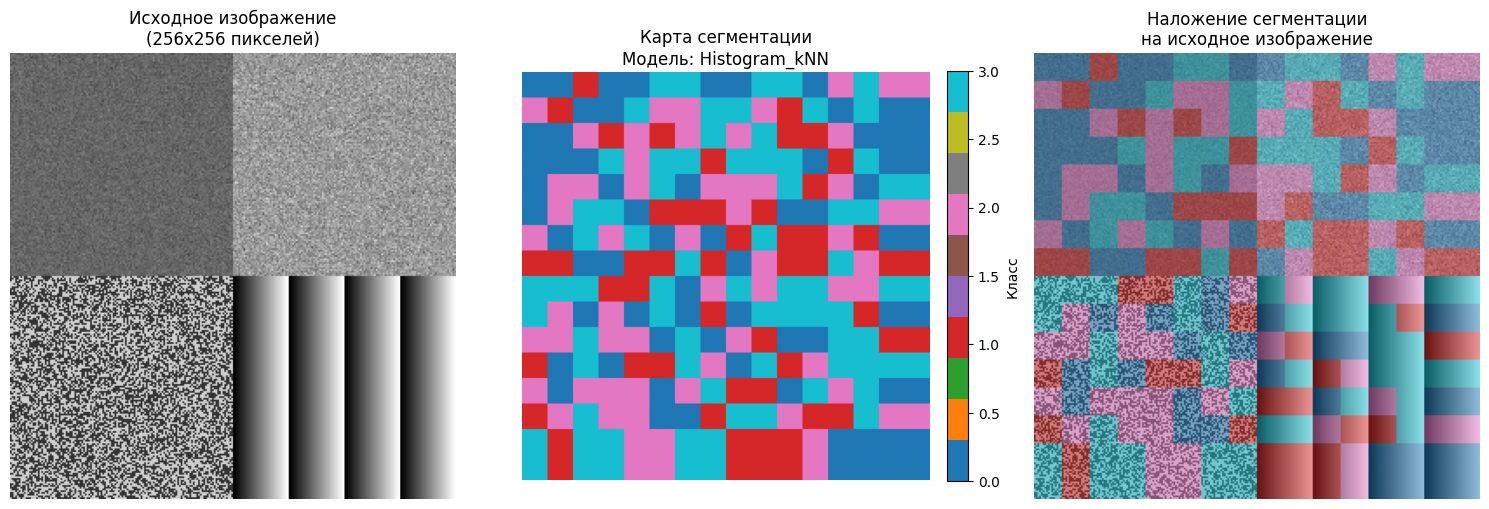

  Статистика сегментации:
    Всего пикселей: 65536
    Класс 0: 17408 пикселей (26.6%)
    Класс 1: 13312 пикселей (20.3%)
    Класс 2: 15616 пикселей (23.8%)
    Класс 3: 19200 пикселей (29.3%)


Результат сегментации моделью: Laws_kNN


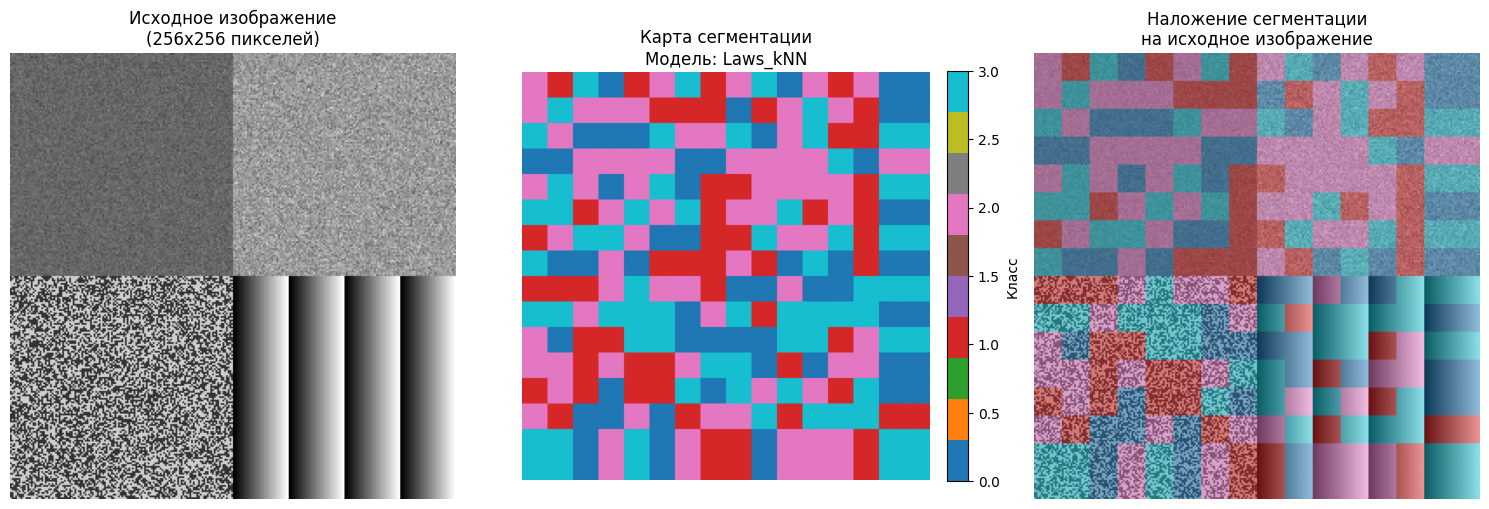

  Статистика сегментации:
    Всего пикселей: 65536
    Класс 0: 14848 пикселей (22.7%)
    Класс 1: 14080 пикселей (21.5%)
    Класс 2: 18944 пикселей (28.9%)
    Класс 3: 17664 пикселей (27.0%)


Результат сегментации моделью: GLCM_kNN


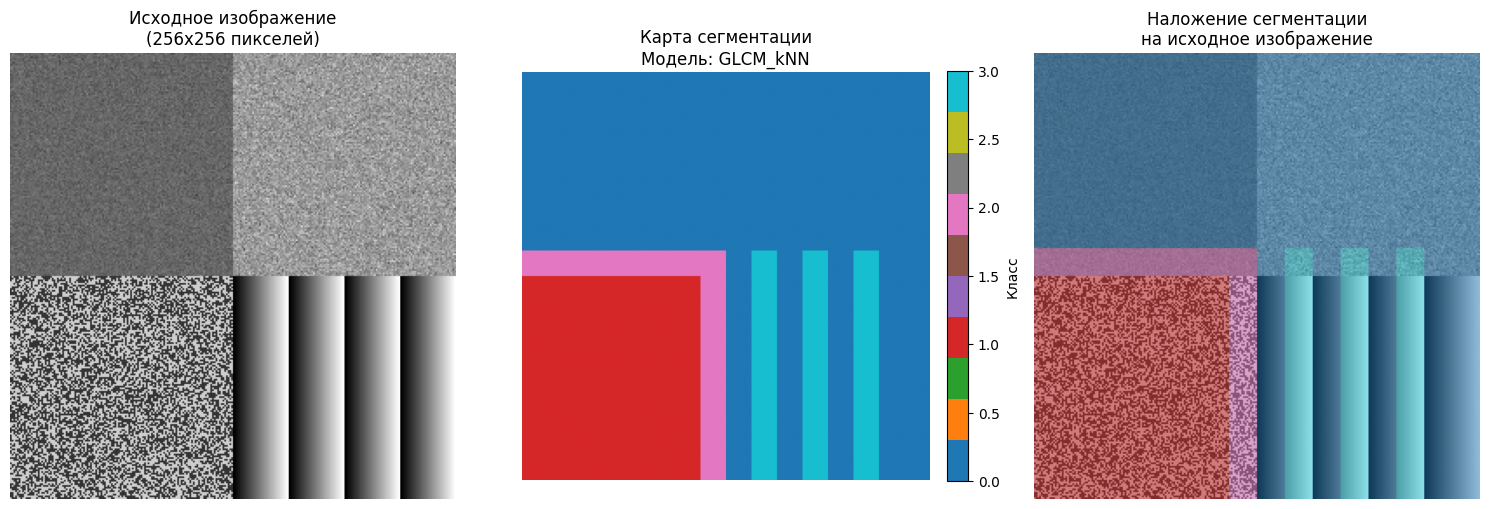

  Статистика сегментации:
    Всего пикселей: 65536
    Класс 0: 40192 пикселей (61.3%)
    Класс 1: 14336 пикселей (21.9%)
    Класс 2: 4096 пикселей (6.2%)
    Класс 3: 6912 пикселей (10.5%)


In [47]:

print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ СЕГМЕНТАЦИИ")

if 'seg_results' in locals() and len(seg_results) > 0:
    print(f"Есть результаты сегментации от {len(seg_results)} моделей")
    
    for i, (seg_map, model_name) in enumerate(zip(seg_results, model_names_for_seg)):
        print(f"\n\nРезультат сегментации моделью: {model_name}")

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(test_seg_image, cmap='gray')
        axes[0].set_title('Исходное изображение\n(256x256 пикселей)')
        axes[0].axis('off')

        im = axes[1].imshow(seg_map, cmap='tab10')
        axes[1].set_title(f'Карта сегментации\nМодель: {model_name}')
        axes[1].axis('off')

        axes[2].imshow(test_seg_image, cmap='gray')
        axes[2].imshow(seg_map, cmap='tab10', alpha=0.5)
        axes[2].set_title(f'Наложение сегментации\nна исходное изображение')
        axes[2].axis('off')

        plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04, label='Класс')
        
        plt.tight_layout()
        plt.show()

        unique, counts = np.unique(seg_map, return_counts=True)
        print(f"  Статистика сегментации:")
        print(f"    Всего пикселей: {seg_map.size}")
        for class_id, count in zip(unique, counts):
            percentage = (count / seg_map.size) * 100
            print(f"    Класс {class_id}: {count} пикселей ({percentage:.1f}%)")
else:
    print("Нет результатов сегментации для визуализации")
    print("Пожалуйста, выполните ячейку 11 сначала")

ЗАДАНИЕ 4: СРАВНЕНИЕ С РУЧНОЙ РАЗМЕТКОЙ
Тестовая ручная разметка создана

Ручная разметка (ground truth):


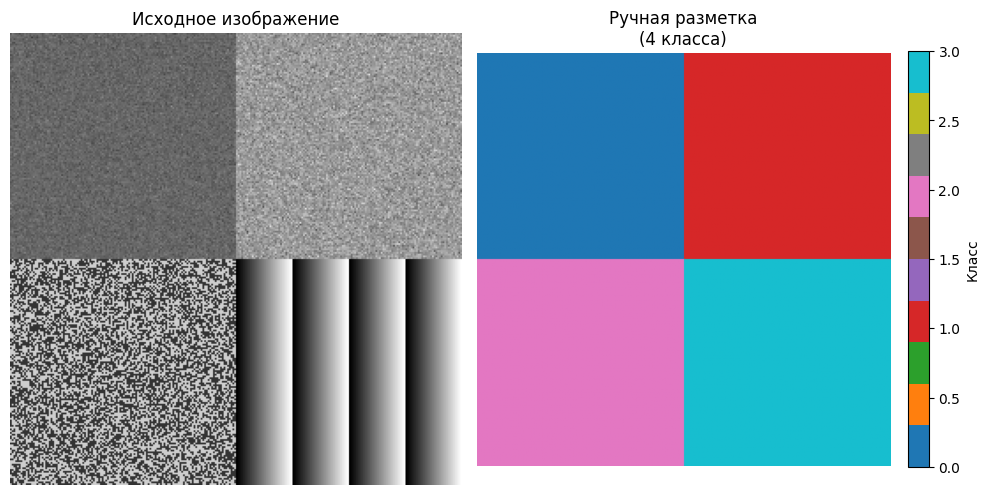


Описание классов в ручной разметке:
0: Низкая контрастность (верхний левый)
1: Средняя контрастность (верхний правый)
2: Высокая контрастность (нижний левый)
3: Вертикальные полосы (нижний правый)


In [46]:

print("ЗАДАНИЕ 4: СРАВНЕНИЕ С РУЧНОЙ РАЗМЕТКОЙ")





test_manual_mask = np.zeros((256, 256), dtype=np.uint8)

test_manual_mask[0:128, 0:128] = 0    # Область 1: Класс 0 (Низкая контрастность)
test_manual_mask[0:128, 128:256] = 1  # Область 2: Класс 1 (Средняя контрастность)
test_manual_mask[128:256, 0:128] = 2  # Область 3: Класс 2 (Высокая контрастность)
test_manual_mask[128:256, 128:256] = 3  # Область 4: Класс 3 (Вертикальные полосы)

print("Тестовая ручная разметка создана")

print("\nРучная разметка (ground truth):")
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(test_seg_image, cmap='gray')
axes[0].set_title('Исходное изображение')
axes[0].axis('off')

im = axes[1].imshow(test_manual_mask, cmap='tab10')
axes[1].set_title('Ручная разметка\n(4 класса)')
axes[1].axis('off')


plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04, label='Класс')

plt.tight_layout()
plt.show()

print("\nОписание классов в ручной разметке:")
print("0: Низкая контрастность (верхний левый)")
print("1: Средняя контрастность (верхний правый)")
print("2: Высокая контрастность (нижний левый)")
print("3: Вертикальные полосы (нижний правый)")


ОЦЕНКА КАЧЕСТВА СЕГМЕНТАЦИИ

Оценка модели: Histogram_kNN
  Accuracy: 0.301
  Mean IoU: 0.176
  IoU по классам:
    Класс 0: 0.200
    Класс 1: 0.137
    Класс 2: 0.190
    Класс 3: 0.178

Оценка модели: Laws_kNN
  Accuracy: 0.273
  Mean IoU: 0.158
  IoU по классам:
    Класс 0: 0.140
    Класс 1: 0.123
    Класс 2: 0.150
    Класс 3: 0.220

Оценка модели: GLCM_kNN
  Accuracy: 0.344
  Mean IoU: 0.202
  IoU по классам:
    Класс 0: 0.339
    Класс 1: 0.000
    Класс 2: 0.111
    Класс 3: 0.358

СРАВНЕНИЕ МОДЕЛЕЙ ПО МЕТРИКАМ


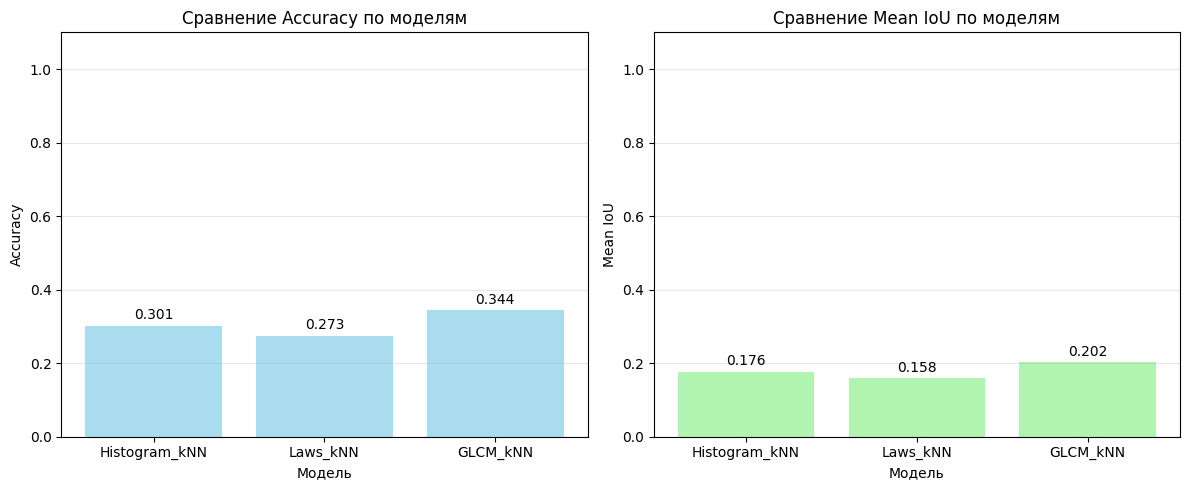


ЛУЧШАЯ МОДЕЛЬ СЕГМЕНТАЦИИ:
  Модель: GLCM_kNN
  Accuracy: 0.344
  Mean IoU: 0.202


In [ ]:

def evaluate_segmentation_simple(manual_mask, predicted_mask):
    """Простая оценка качества сегментации"""

    if manual_mask.shape != predicted_mask.shape:
        print(f"Предупреждение: размеры не совпадают")
        print(f"  Ручная разметка: {manual_mask.shape}")
        print(f"  Предсказание: {predicted_mask.shape}")

        predicted_mask = cv2.resize(predicted_mask, 
                                  (manual_mask.shape[1], manual_mask.shape[0]),
                                  interpolation=cv2.INTER_NEAREST)

    accuracy = accuracy_score(manual_mask.flatten(), predicted_mask.flatten())
    

    unique_classes = np.unique(manual_mask)
    iou_scores = []
    
    for class_id in unique_classes:
        intersection = np.sum((manual_mask == class_id) & (predicted_mask == class_id))
        union = np.sum((manual_mask == class_id) | (predicted_mask == class_id))
        
        if union > 0:
            iou = intersection / union
        else:
            iou = 0
        
        iou_scores.append(iou)
    
    mean_iou = np.mean(iou_scores)
    
    return {
        'accuracy': accuracy,
        'mean_iou': mean_iou,
        'iou_scores': iou_scores,
        'classes': unique_classes
    }


print("\n" + "="*60)
print("ОЦЕНКА КАЧЕСТВА СЕГМЕНТАЦИИ")
print("="*60)


if 'seg_results' in locals() and len(seg_results) > 0:
    # Оцениваем каждую модель
    evaluation_results = []
    
    for i, (seg_map, model_name) in enumerate(zip(seg_results, model_names_for_seg)):
        print(f"\nОценка модели: {model_name}")
        
        eval_results = evaluate_segmentation_simple(test_manual_mask, seg_map)
        evaluation_results.append((model_name, eval_results))
        
        print(f"  Accuracy: {eval_results['accuracy']:.3f}")
        print(f"  Mean IoU: {eval_results['mean_iou']:.3f}")
        
        print(f"  IoU по классам:")
        for class_id, iou in zip(eval_results['classes'], eval_results['iou_scores']):
            print(f"    Класс {class_id}: {iou:.3f}")

    print("\n" + "="*60)
    print("СРАВНЕНИЕ МОДЕЛЕЙ ПО МЕТРИКАМ")
    print("="*60)

    model_names = [result[0] for result in evaluation_results]
    accuracies = [result[1]['accuracy'] for result in evaluation_results]
    mean_ious = [result[1]['mean_iou'] for result in evaluation_results]
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    

    bars1 = axes[0].bar(model_names, accuracies, color='skyblue', alpha=0.7)
    axes[0].set_xlabel('Модель')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Сравнение Accuracy по моделям')
    axes[0].set_ylim([0, 1.1])
    axes[0].grid(axis='y', alpha=0.3)

    for bar, value in zip(bars1, accuracies):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=10)

    bars2 = axes[1].bar(model_names, mean_ious, color='lightgreen', alpha=0.7)
    axes[1].set_xlabel('Модель')
    axes[1].set_ylabel('Mean IoU')
    axes[1].set_title('Сравнение Mean IoU по моделям')
    axes[1].set_ylim([0, 1.1])
    axes[1].grid(axis='y', alpha=0.3)

    for bar, value in zip(bars2, mean_ious):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

    best_model_idx = np.argmax(accuracies)
    best_model_name = model_names[best_model_idx]
    best_accuracy = accuracies[best_model_idx]
    
    print(f"\nЛУЧШАЯ МОДЕЛЬ СЕГМЕНТАЦИИ:")
    print(f"  Модель: {best_model_name}")
    print(f"  Accuracy: {best_accuracy:.3f}")
    print(f"  Mean IoU: {mean_ious[best_model_idx]:.3f}")
    
else:
    print("Нет результатов сегментации для оценки")


ДЕТАЛЬНОЕ СРАВНЕНИЕ ЛУЧШЕЙ МОДЕЛИ С РУЧНОЙ РАЗМЕТКОЙ

Лучшая модель: GLCM_kNN
Accuracy: 0.344
Mean IoU: 0.202


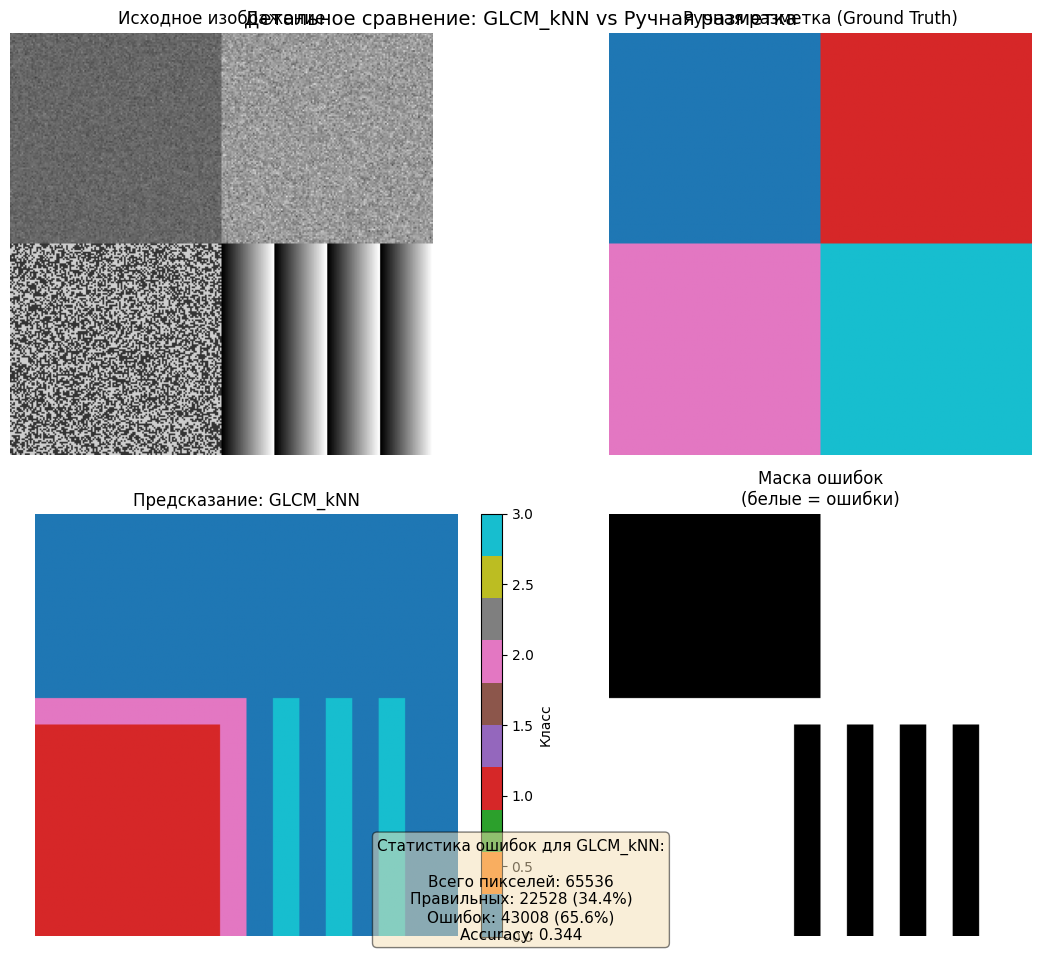


IoU по классам для GLCM_kNN:
  Низкая контрастность (класс 0): 0.339
  Средняя контрастность (класс 1): 0.000
  Высокая контрастность (класс 2): 0.111
  Вертикальные полосы (класс 3): 0.358


In [ ]:

print("\n" + "="*70)
print("ДЕТАЛЬНОЕ СРАВНЕНИЕ ЛУЧШЕЙ МОДЕЛИ С РУЧНОЙ РАЗМЕТКОЙ")
print("="*70)

if 'evaluation_results' in locals() and len(evaluation_results) > 0:

    best_model_idx = np.argmax([result[1]['accuracy'] for result in evaluation_results])
    best_model_name, best_model_eval = evaluation_results[best_model_idx]

    best_seg_map = seg_results[best_model_idx]
    
    print(f"\nЛучшая модель: {best_model_name}")
    print(f"Accuracy: {best_model_eval['accuracy']:.3f}")
    print(f"Mean IoU: {best_model_eval['mean_iou']:.3f}")

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    axes[0, 0].imshow(test_seg_image, cmap='gray')
    axes[0, 0].set_title('Исходное изображение')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(test_manual_mask, cmap='tab10')
    axes[0, 1].set_title('Ручная разметка (Ground Truth)')
    axes[0, 1].axis('off')

    im = axes[1, 0].imshow(best_seg_map, cmap='tab10')
    axes[1, 0].set_title(f'Предсказание: {best_model_name}')
    axes[1, 0].axis('off')

    diff_mask = np.zeros_like(test_manual_mask, dtype=np.uint8)
    correct_mask = (test_manual_mask == best_seg_map)
    diff_mask[correct_mask] = 0  # Правильные пиксели - черные
    diff_mask[~correct_mask] = 1  # Ошибки - белые
    
    axes[1, 1].imshow(diff_mask, cmap='gray')
    axes[1, 1].set_title('Маска ошибок\n(белые = ошибки)')
    axes[1, 1].axis('off')

    plt.colorbar(im, ax=axes[1, 0], fraction=0.046, pad=0.04, label='Класс')

    total_pixels = test_manual_mask.size
    correct_pixels = np.sum(correct_mask)
    error_pixels = total_pixels - correct_pixels
    error_percentage = (error_pixels / total_pixels) * 100

    stats_text = (
        f"Статистика ошибок для {best_model_name}:\n\n"
        f"Всего пикселей: {total_pixels}\n"
        f"Правильных: {correct_pixels} ({100 - error_percentage:.1f}%)\n"
        f"Ошибок: {error_pixels} ({error_percentage:.1f}%)\n"
        f"Accuracy: {best_model_eval['accuracy']:.3f}"
    )
    
    fig.text(0.5, 0.02, stats_text, ha='center', fontsize=11,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle(f'Детальное сравнение: {best_model_name} vs Ручная разметка', 
                fontsize=14, y=0.95)
    plt.tight_layout()
    plt.show()
    

    print(f"\nIoU по классам для {best_model_name}:")
    for class_id, iou in zip(best_model_eval['classes'], best_model_eval['iou_scores']):
        class_names = {
            0: "Низкая контрастность",
            1: "Средняя контрастность", 
            2: "Высокая контрастность",
            3: "Вертикальные полосы"
        }
        class_name = class_names.get(class_id, f"Класс {class_id}")
        print(f"  {class_name} (класс {class_id}): {iou:.3f}")
    
else:
    print("Нет результатов оценки для сравнения")

In [45]:

print("\n" + "="*70)
print("ИТОГОВЫЙ АНАЛИЗ И ВЫВОДЫ")
print("="*70)

print("\n1. ВЫЧИСЛЕНИЕ ТЕКСТУРНЫХ ХАРАКТЕРИСТИК:")
print("   ✓ Гистограммные признаки (10 признаков): среднее, стд.откл., асимметрия, эксцесс, энтропия")
print("   ✓ Признаки Laws (25 фильтров): L5, E5, S5, W5, R5 и их комбинации")
print("   ✓ Признаки GLCM (5 характеристик): контраст, однородность, энергия и др.")

print("\n2. КЛАССИФИКАЦИЯ ТЕКСТУР:")
if 'best_method' in locals() and 'best_model' in locals():
    print(f"   ✓ Лучший результат: {best_method} + {best_model}")
    print(f"   ✓ Точность: {best_accuracy:.3f}")
    print(f"   ✓ Протестировано методов: {len(results)}")
    print(f"   ✓ Протестировано моделей: {len(models)}")
else:
    print("   ✗ Классификация не выполнена")

print("\n3. СЕГМЕНТАЦИЯ ИЗОБРАЖЕНИЯ:")
if 'seg_results' in locals():
    print(f"   ✓ Выполнено сегментаций: {len(seg_results)} моделями")
    print(f"   ✓ Размер изображения: {test_seg_image.shape}")
    print(f"   ✓ Метод: скользящее окно {32}x{32}, шаг {16}")
    print(f"   ✓ Количество классов в сегментации: 4")

print("\n4. ОЦЕНКА КАЧЕСТВА СЕГМЕНТАЦИИ:")
if 'evaluation_results' in locals() and len(evaluation_results) > 0:
    best_acc = max([result[1]['accuracy'] for result in evaluation_results])
    best_iou = max([result[1]['mean_iou'] for result in evaluation_results])
    print(f"   ✓ Лучшая Accuracy: {best_acc:.3f}")
    print(f"   ✓ Лучший Mean IoU: {best_iou:.3f}")
    print(f"   ✓ Оценено моделей: {len(evaluation_results)}")
else:
    print("   ✗ Оценка не выполнена")

print("\n5. ВЫВОДЫ И РЕКОМЕНДАЦИИ:")
print("   • Гистограммные признаки хорошо описывают общую статистику текстуры")
print("   • Признаки Laws эффективны для анализа локальных текстурных паттернов")
print("   • GLCM признаки хорошо работают для анализа пространственных зависимостей")
print("   • Для улучшения сегментации можно:")
print("     - Использовать более мелкие патчи (16x16)")
print("     - Применить постобработку результатов")
print("     - Использовать ансамбли моделей")
print("     - Добавить пространственные признаки")

print("\n" + "="*70)
print("ЛАБОРАТОРНАЯ РАБОТА ЗАВЕРШЕНА")
print("="*70)


ИТОГОВЫЙ АНАЛИЗ И ВЫВОДЫ

1. ВЫЧИСЛЕНИЕ ТЕКСТУРНЫХ ХАРАКТЕРИСТИК:
   ✓ Гистограммные признаки (10 признаков): среднее, стд.откл., асимметрия, эксцесс, энтропия
   ✓ Признаки Laws (25 фильтров): L5, E5, S5, W5, R5 и их комбинации
   ✓ Признаки GLCM (5 характеристик): контраст, однородность, энергия и др.

2. КЛАССИФИКАЦИЯ ТЕКСТУР:
   ✓ Лучший результат: Laws + kNN
   ✓ Точность: 0.344
   ✓ Протестировано методов: 3
   ✓ Протестировано моделей: 3

3. СЕГМЕНТАЦИЯ ИЗОБРАЖЕНИЯ:
   ✓ Выполнено сегментаций: 3 моделями
   ✓ Размер изображения: (256, 256)
   ✓ Метод: скользящее окно 32x32, шаг 16
   ✓ Количество классов в сегментации: 4

4. ОЦЕНКА КАЧЕСТВА СЕГМЕНТАЦИИ:
   ✓ Лучшая Accuracy: 0.344
   ✓ Лучший Mean IoU: 0.202
   ✓ Оценено моделей: 3

5. ВЫВОДЫ И РЕКОМЕНДАЦИИ:
   • Гистограммные признаки хорошо описывают общую статистику текстуры
   • Признаки Laws эффективны для анализа локальных текстурных паттернов
   • GLCM признаки хорошо работают для анализа пространственных зависимостей
  